# sMRI Clean-up

---

Objectives:

* Visualize bias fields and motion artifacts
* Generate brain masks

## Why do we need image clean-ups?

Correcting or cleaning -up certain artifacts from the raw (i.e. acquired) MR scans is crucial for the successful processing of subsequent image normalization tasks as well as the downstream statistical analyses. Some version of these two tasks is implemented in all commonly deployed processing pipelines such as `FreeSufer`, `FSL`, etc.

### Intensity normalization (bias field correction; intensity inhomogeneity correction)

* The bias field is a low-frequency spatially varying MRI artifact resulting from spatial inhomogeneity of the magnetic field, variations in the sensitivity of the reception coil, and the interaction between the magnetic field and the human body.
* It causes a smooth signal intensity variation within tissue of the same physical properties.
* The bias field is dependent on the strength of the magnetic field. If it is not corrected for 1.5T or higher MR scanner, it can considerably affect downstream analyses. Stronger magnets will induce higher bias.
* Commonly used tools:
  * [ANTs N4 bias correction](https://pubmed.ncbi.nlm.nih.gov/20378467/)
  * [FSL FAST](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FAST) (Note: FSL FAST is a multi-purpose segmentation tool that includes the bias field correction.)

> What is the difference between bias field and image noise?

Bias field is modeled as multiplicative factor, whereas noise is typically assumed as additive and spatially independent (Gaussian) factor.

i.e. $v(x)=u(x)f(x)+n(x)$, where $v$ is the given image, $u$ is the uncorrupted image, $f$ is the bias field, $u$ is the uncorrupted image, and $n$ is the noise.

Presence of artifacts can lead to flawed analysis and incorrect findings.

### ANTs N4 correction

![N4 Bias](imgs/N4_bias.jpeg)

(a) Acquired T1w image. (b) Estimated the bias field which can then be used to *correct* the image. (c) Bias field viewed as a surface to show the low frequency modulation.

[ANTs](http://stnava.github.io/ANTs/) is a software comprising several tools and image processing algorithms. ANTs can be run independently or we can import ANTs scripts in Python using `nipype` library.

## Dataset

Here we will be using a subset of [AMOIC](https://nilab-uva.github.io/AOMIC.github.io/): the Amsterdam Open MRI collection from [OpenNeuro](https://openneuro.org/datasets/ds002790/versions/2.0.0).

The anatomical data along with the processed derivatives are conveniently organized in BIDS format.

The downloaded data for `sub-0001` or `sub-0002` in the `local_data/AOMIC` directory.

In [21]:
import seedir as sd

sd.seedir("local_data/AOMIC", style="emoji")

📁 AOMIC/
├─📄 CHANGES
├─📄 dataset_description.json
├─📁 derivatives/
│ ├─📁 fmriprep/
│ │ ├─📄 dataset_description.json
│ │ ├─📁 sub-0001/
│ │ │ ├─📁 anat/
│ │ │ │ ├─📄 sub-0001_desc-aparcaseg_dseg.nii.gz
│ │ │ │ ├─📄 sub-0001_desc-aseg_dseg.nii.gz
│ │ │ │ ├─📄 sub-0001_desc-brain_mask.json
│ │ │ │ ├─📄 sub-0001_desc-brain_mask.nii.gz
│ │ │ │ ├─📄 sub-0001_desc-preproc_T1w.json
│ │ │ │ ├─📄 sub-0001_desc-preproc_T1w.nii.gz
│ │ │ │ ├─📄 sub-0001_dseg.nii.gz
│ │ │ │ ├─📄 sub-0001_from-MNI152NLin2009cAsym_to-T1w_mode-image_xfm.h5
│ │ │ │ ├─📄 sub-0001_from-orig_to-T1w_mode-image_xfm.txt
│ │ │ │ ├─📄 sub-0001_from-T1w_to-fsnative_mode-image_xfm.txt
│ │ │ │ ├─📄 sub-0001_from-T1w_to-MNI152NLin2009cAsym_mode-image_xfm.h5
│ │ │ │ ├─📄 sub-0001_hemi-L_inflated.surf.gii
│ │ │ │ ├─📄 sub-0001_hemi-L_midthickness.surf.gii
│ │ │ │ ├─📄 sub-0001_hemi-L_pial.surf.gii
│ │ │ │ ├─📄 sub-0001_hemi-L_smoothwm.surf.gii
│ │ │ │ ├─📄 sub-0001_hemi-R_inflated.surf.gii
│ │ │ │ ├─📄 sub-0001_hemi-R_midthickness.surf.gii
│ │ │ │ ├─📄 

### Reading data

In [22]:
local_data_dir = 'local_data/AOMIC/'

subject_id = 'sub-0001' # or 'sub-0002'

fmri_prep_output_dir = local_data_dir + 'derivatives/fmpriprep/{}/anat/'.format(subject_id)
freesurfer_output_dir = local_data_dir + 'derivatives/freesurfer/{}/mri/'.format(subject_id)

print('Using {}'.format(subject_id))
subject_T1 = local_data_dir + '{}/anat/{}_T1w.nii.gz'.format(subject_id, subject_id)
subject_T1_N4_corrected = fmri_prep_output_dir + '{}_desc-preproc_T1w.nii.gz'.format(subject_id)

Using sub-0001


In [23]:
from bids import BIDSLayout

bids_data_dir = 'local_data/AOMIC'
bids_layout = BIDSLayout(bids_data_dir, derivatives=True)

subject_list = bids_layout.get_subjects()
print("Available subjects in the BIDS datasets:\n{}".format(subject_list))

C:\Language\Miniconda3\lib\site-packages\bids\layout\validation.py:149: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Available subjects in the BIDS datasets:
['0008', '0009', '0002', '0010', '0006', '0007', '0005', '0004', '0003', '0001']


In [24]:
subject_T1 = bids_layout.get(subject="0001",
                             datatype='anat',
                             scope='raw',
                             extension='nii.gz',
                             return_type='filename')[0]

subject_T1_N4_corrected = bids_layout.get(subject="0001",
                                          scope="derivatives",
                                          datatype="anat",
                                          suffix="T1w",
                                          desc="preproc",
                                          extension="nii.gz",
                                          return_type="filename")[0]

print(f"subject T1 path:\n{subject_T1}")
print(f"\nsubject T1 corrected path:\n{subject_T1_N4_corrected}")

subject T1 path:
E:\Workspace\Tutorials\Working-with-MRI-Data-in-Python\sMRI\local_data\AOMIC\sub-0001\anat\sub-0001_T1w.nii.gz

subject T1 corrected path:
E:\Workspace\Tutorials\Working-with-MRI-Data-in-Python\sMRI\local_data\AOMIC\derivatives\fmriprep\sub-0001\anat\sub-0001_desc-preproc_T1w.nii.gz


## Clean-up tasks

### 1. Bias correction (intensity normalization)

Using [ANTs and NiPype](https://pythonhosted.org/nipype/interfaces/generated/nipype.interfaces.ants.segmentation.html#n4biasfieldcorrection)

Try using the snippet below first to check if the installation is ready.

In [25]:
#import nipype.pipeline.engine as pe
#from nipype.interfaces.utility import IdentityInterface
#from nipype.interfaces.ants import N4BiasFieldCorrection
#from nipype.interfaces.io import SelectFiles, DataSink

#my_brain_image = 'local_data/AOMIC/sub-0001/anat/sub-0001_T1w.nii.gz'

#n4 = N4BiasFieldCorrection()
#n4.inputs.dimension = 3
#n4.inputs.input_image = my_brain_image
#n4.inputs.bspline_fitting_distance = 300
#n4.inputs.shrink_factor = 3
#n4.inputs.n_iterations = [50, 50, 30, 20]
#n4.inputs.output_image = my_brain_image.replace('.nii.gz', '_N4_corrected.nii.gz')

#n4.run()

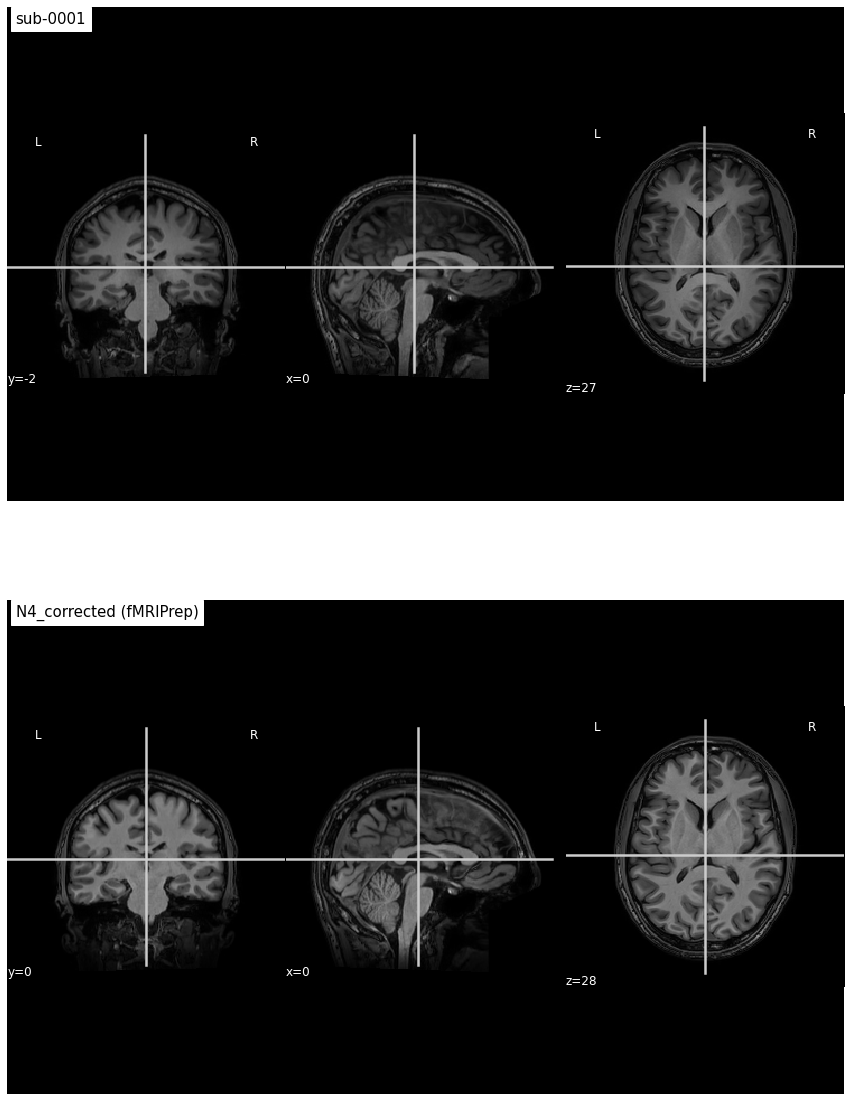

In [26]:
import matplotlib.pyplot as plt
import nibabel as nib
from nilearn import plotting

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 20))

# plot waw scan
vmax = 0.7 * nib.load(subject_T1).get_fdata().max()
plotting.plot_anat(subject_T1, title=subject_id, vmax=vmax, axes=ax1)

# Plot corrected image
vmax = 0.7 * nib.load(subject_T1_N4_corrected).get_fdata().max()
plotting.plot_anat(subject_T1_N4_corrected, title='N4_corrected (fMRIPrep)', vmax=vmax, axes=ax2)

using precomputed FreeSurfer output. Files used:
* `orig.mgz`: input (raw) T1 image
* `nu.mgz`: [Output](https://surfer.nmr.mgh.harvard.edu/fswiki/nuintensitycor) of non-parametric Non-uniform intensity Normalization (N3)
* `T1.mgz`: [Output](https://surfer.nmr.mgh.harvard.edu/fswiki/normalization) of intensity normalization of the orig volume to correct for fluctuations in intensity that would otherwise make intensity-based segmentation much more difficult. Intensities for all voxels are scaled so that the mean intensity of the white matter is `110`.

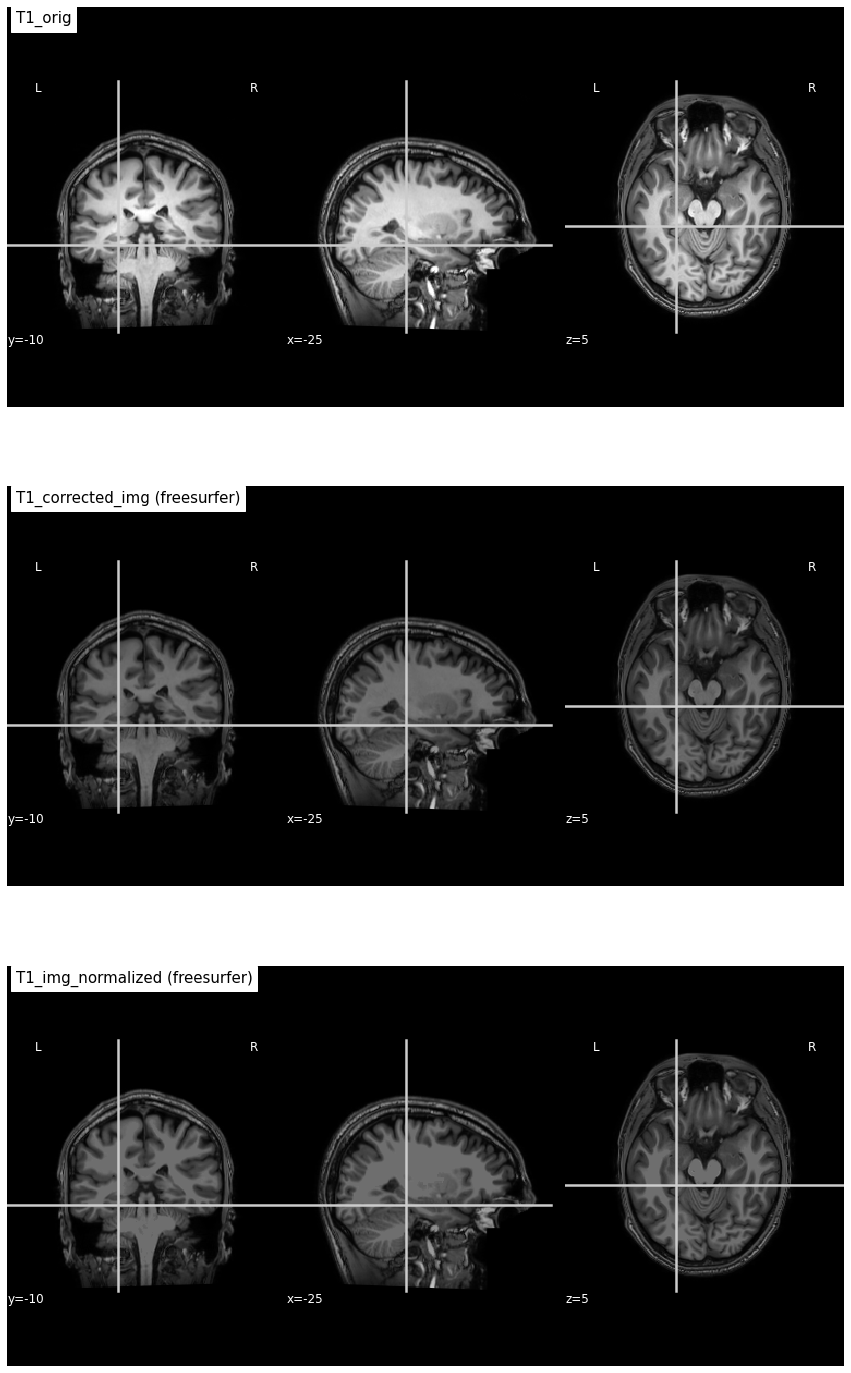

In [27]:
T1_orig = freesurfer_output_dir + 'orig.mgz'
T1_corrected = freesurfer_output_dir + 'nu.mgz'
T1_normalized = freesurfer_output_dir + 'T1.mgz'

cut_coords = (-25, -10, 5)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 25))

plotting.plot_anat(T1_orig, title="T1_orig", cut_coords=cut_coords, vmax=255, axes=ax1)
plotting.plot_anat(T1_corrected, title="T1_corrected_img (freesurfer)", cut_coords=cut_coords, vmax=255, axes=ax2)
plotting.plot_anat(T1_normalized, title="T1_img_normalized (freesurfer)", cut_coords=cut_coords, vmax=255, axes=ax3)

plot intensity histogram.

In [28]:
import numpy as np

T1_data_orig = nib.load(T1_orig).get_fdata()
T1_data_corrected = nib.load(T1_corrected).get_fdata()
T1_data_normalized = nib.load(T1_normalized).get_fdata()

print(f"Data shapes, orig: {T1_data_orig.shape}, corrected: {T1_data_corrected.shape}, normalized: {T1_data_normalized.shape}")
print(f"Intensity ranges\n\torig min: {np.min(T1_data_orig)}, max: {np.max(T1_data_orig)}\n\tcorrected min: {np.min(T1_data_corrected)}, max: {np.max(T1_data_corrected)}\n\tnormalized min: {np.min(T1_data_normalized)}, max: {np.max(T1_data_normalized)}")

Data shapes, orig: (256, 256, 256), corrected: (256, 256, 256), normalized: (256, 256, 256)
Intensity ranges
	orig min: 0.0, max: 255.0
	corrected min: 0.0, max: 203.0
	normalized min: 0.0, max: 209.0


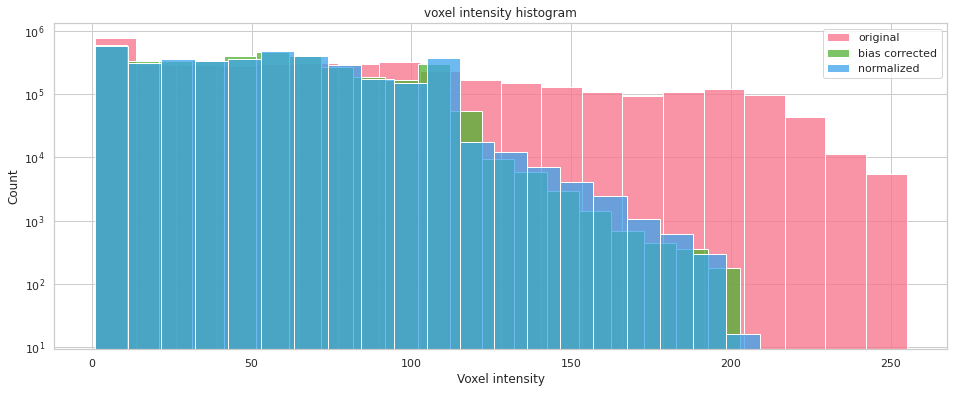

In [29]:
import seaborn as sns

T1_data_orig = T1_data_orig.ravel()
T1_data_orig = T1_data_orig[np.nonzero(T1_data_orig)]

T1_data_corrected = T1_data_corrected.ravel()
T1_data_corrected = T1_data_corrected[np.nonzero(T1_data_corrected)]

T1_data_normalized = T1_data_normalized.ravel()
T1_data_normalized = T1_data_normalized[np.nonzero(T1_data_normalized)]

sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})
palette = sns.color_palette("husl", 3)

with sns.axes_style("whitegrid"):
    plt.figure(figsize=(16, 6))
    g = sns.histplot(T1_data_orig, bins=20, kde=False, color=palette[0], log_scale=(False, True), label='original')
    g = sns.histplot(T1_data_corrected, bins=20, kde=False, color=palette[1], log_scale=(False, True), label='bias corrected')
    g = sns.histplot(T1_data_normalized, bins=20, kde=False, color=palette[2], log_scale=(False, True), label='normalized')


    plt.legend()
    plt.xlabel('Voxel intensity')
    plt.title('voxel intensity histogram')

### 2. Brain extraction

* Image contrasts from nonbrain tissues such as fat, skull, or neck can cause issues with downstream analyses starting with brain tissue segmentation
* The brain extraction generates a mask that identifies brain voxels comprising grey-matter (GM), white-matter (WM), and Cerebrospinal fluid (CSF) of the cerebral cortex and subcortical structures, including the brain stem and cerebellum.
* The scalp, dura matter, fat, skin, muscles, eyes, and bones are classified as nonbrain voxels.

We are just creating a simple brain mask for computational purposes, which need not capture the precise brain anatomy. Thus you may see some marrow and membrain included in the extracted brain.

Example brain extractions pass / fail

Pass           |  Fail
:-------------------------:|:-------------------------:
![Pass](imgs/BET_Brain_mask_QC_pass.png)  |  ![Fail](imgs/BET_Brain_mask_QC_fail.png)

Brain mask at this stage only offers a crude estimate about total brain volume. It can be used for quality control (e.g. detecting preprocessing algorithm failures). More accurate estimates of total brain and intracranial volumes are calculated in subsequent steps, which are used as covariates or normalizing factors in statistical analysis.

Using ANTs and NIPype if you have installed packages correctly.


In [30]:
#from nipype.interfaces.ants.segmentation import  BrainExtraction

#brainextraction = BrainExtraction()
#brainextraction.inputs.dimension = 3
#brainextraction.inputs.anatomical_image = 'T1.nii.gz'
#brainextraction.inputs.brain_template = 'study_template.nii.gz'
#brainextraction.inputs.brain_probability_mask = 'ProbabilityMaskOfStudyTemplate.nii.gz'
#print(brainextraction.cmdline)

Read fMRIPrep data using `pybids` package.

In [31]:
subject_T1_N4_corrected = bids_layout.get(subject="0001",
                                          scope="derivatives",
                                          datatype="anat",
                                          suffix="T1w",
                                          desc="preproc",
                                          extension="nii.gz",
                                          return_type="filename")
subject_T1_brain_mask = bids_layout.get(subject="0001",
                                          scope="derivatives",
                                          datatype="anat",
                                          suffix="mask",
                                          desc="brain",
                                          extension="nii.gz",
                                          return_type="filename")

print(f"subject T1 corrected path:\n{subject_T1_N4_corrected}")
print(f"\nsubject_T1_brain_mask:\n{subject_T1_brain_mask}")

subject T1 corrected path:
['E:\\Workspace\\Tutorials\\Working-with-MRI-Data-in-Python\\sMRI\\local_data\\AOMIC\\derivatives\\fmriprep\\sub-0001\\anat\\sub-0001_desc-preproc_T1w.nii.gz', 'E:\\Workspace\\Tutorials\\Working-with-MRI-Data-in-Python\\sMRI\\local_data\\AOMIC\\derivatives\\fmriprep\\sub-0001\\anat\\sub-0001_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz']

subject_T1_brain_mask:
['E:\\Workspace\\Tutorials\\Working-with-MRI-Data-in-Python\\sMRI\\local_data\\AOMIC\\derivatives\\fmriprep\\sub-0001\\anat\\sub-0001_desc-brain_mask.nii.gz', 'E:\\Workspace\\Tutorials\\Working-with-MRI-Data-in-Python\\sMRI\\local_data\\AOMIC\\derivatives\\fmriprep\\sub-0001\\anat\\sub-0001_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz']


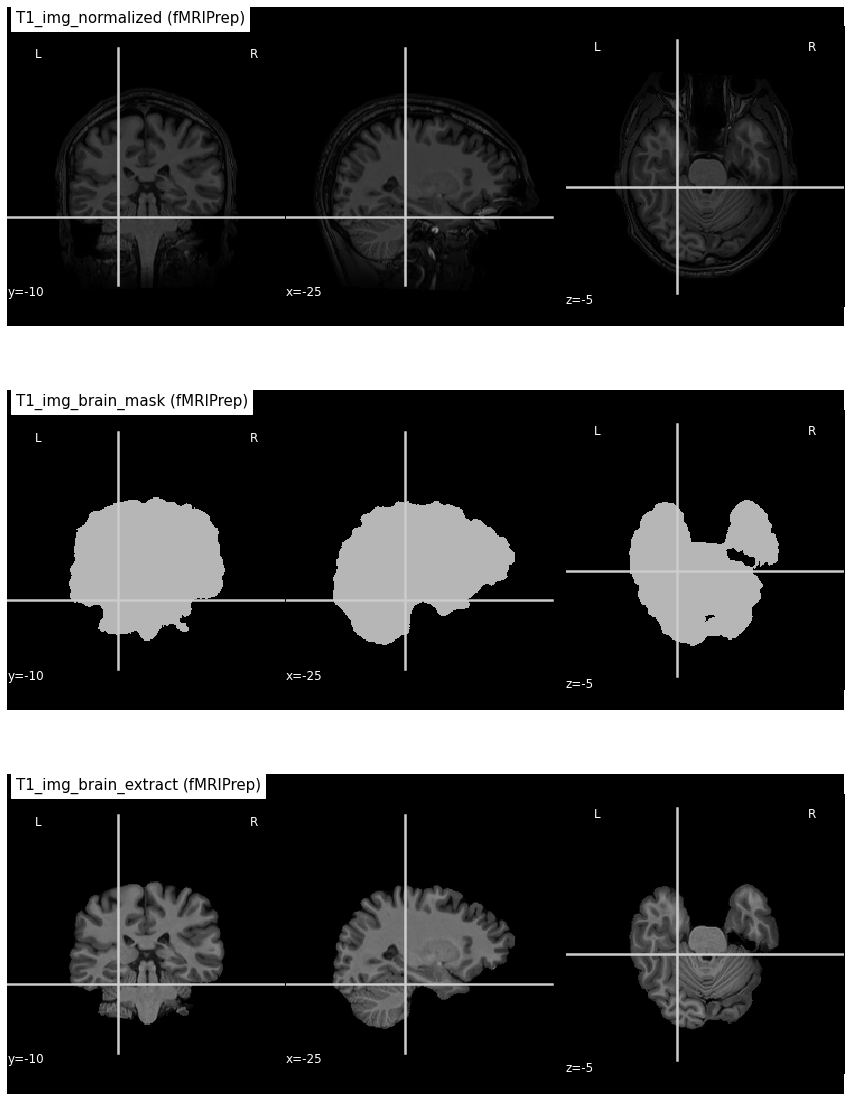

In [32]:
T1_img_normalized = nib.load(subject_T1_N4_corrected[0])
T1_img_brain_mask = nib.load(subject_T1_brain_mask[0])
masked_data = T1_img_normalized.get_fdata() * T1_img_brain_mask.get_fdata()

T1_img_brain_extract = nib.Nifti1Image(masked_data, T1_img_normalized.affine)
cut_coords = (-25, -10, -5)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 20))

plotting.plot_anat(T1_img_normalized, title="T1_img_normalized (fMRIPrep)", cut_coords=cut_coords, axes=ax1)
plotting.plot_anat(T1_img_brain_mask, title="T1_img_brain_mask (fMRIPrep)", cut_coords=cut_coords, axes=ax2)
plotting.plot_anat(T1_img_brain_extract, title="T1_img_brain_extract (fMRIPrep)", cut_coords=cut_coords, axes=ax3)

Using precomputed FreeSurfer output. Compare the original and corrected images.

Files used:
* `T1.mgz`: Normalized MR image
* `brainmask.mgz`: brain extracted (i.e. skull stripped MR image)

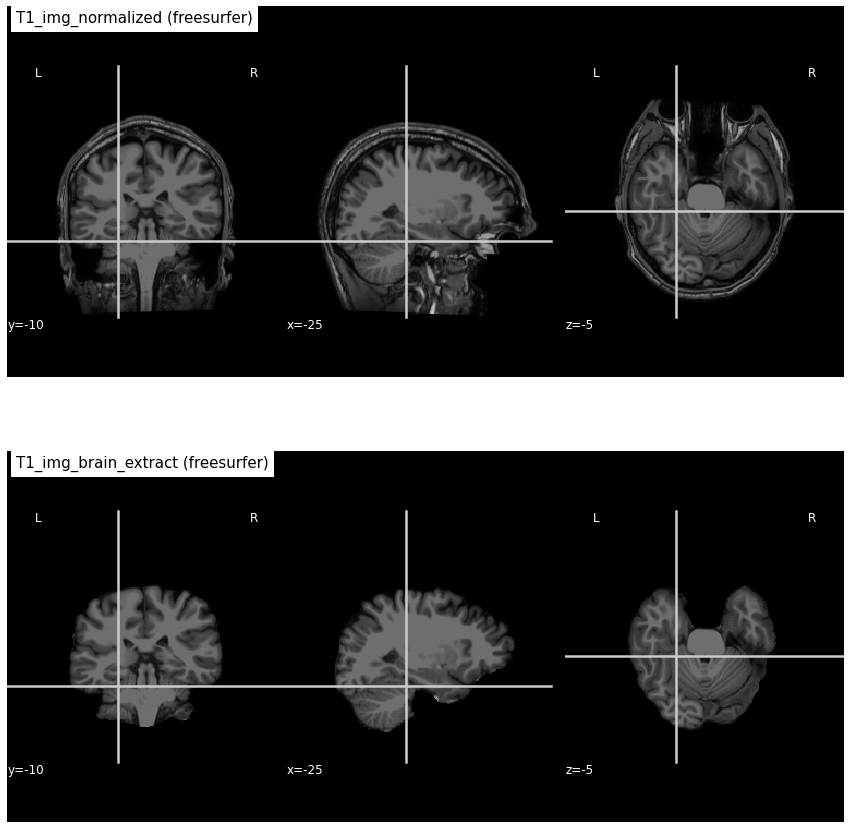

In [33]:
T1_normalized = freesurfer_output_dir + 'T1.mgz'
T1_brain_extract = freesurfer_output_dir + 'brainmask.mgz'

T1_img_normalized = nib.load(T1_normalized)
T1_img_brain_extract = nib.load(T1_brain_extract)

cut_coords = (-25, -10, -5)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15))
plotting.plot_anat(T1_img_normalized, title="T1_img_normalized (freesurfer)", cut_coords=cut_coords, vmax=255, axes=ax1)
plotting.plot_anat(T1_img_brain_extract, title="T1_img_brain_extract (freesurfer)", cut_coords=cut_coords, vmax=255, axes=ax2)